In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
heating_data = pd.read_csv("ECUK_2024_End_Use_tables - Table U3.csv", header=4)

In [4]:
heating_data = heating_data.iloc[1:].reset_index(drop=True)
heating_data = heating_data.dropna(axis=1, how='all')
heating_data = heating_data.rename(columns={heating_data.columns[0]: "Year"})
heating_data["Year"] = pd.to_numeric(heating_data["Year"], errors="coerce")
heating_data = heating_data[(heating_data["Year"] >= 1990) & (heating_data["Year"] <= 2023)]

In [5]:
columns = [
    'Year',
    'Electricity - space heating',
    'Electricity - water heating'
]

In [6]:
heating_data.columns = heating_data.columns.map(lambda x: str(x).strip())

In [7]:
valid_cols = [col for col in columns if col in heating_data.columns]
filtered_heating_data = heating_data[valid_cols].copy()

In [8]:
for col in filtered_heating_data.columns:
    if col != 'Year':
        filtered_heating_data[col] = pd.to_numeric(filtered_heating_data[col].astype(str).str.replace(',', ''), errors='coerce')
        filtered_heating_data[col] = filtered_heating_data[col] * 11.63

In [9]:
print(filtered_heating_data.tail())

    Year  Electricity - space heating  Electricity - water heating
48  2019                     16537.86                      4547.33
49  2020                     16235.48                      4710.15
50  2021                     17130.99                      4838.08
51  2022                     14176.97                      3861.16
52  2023                     13711.77                      3756.49


In [10]:
forecast_years = pd.DataFrame({'Year': list(range(2022, 2031))})
forecast_filtered_heating_data = forecast_years.copy()

for col in filtered_heating_data.columns:
    if col == 'Year':
        continue
    model_data = filtered_heating_data[['Year', col]].dropna()
    if len(model_data) < 3:
        print(f"Not enough data to train polynomial model for column: {col}")
        forecast_filtered_heating_data[col] = np.nan
        continue

    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(model_data[['Year']])
    model = LinearRegression()
    model.fit(X_poly, model_data[col])

    predict = poly.transform(forecast_years[['Year']])
    forecast_filtered_heating_data[col] = model.predict(predict)

    forecast_filtered_heating_data[col] = np.maximum( forecast_filtered_heating_data[col], 300)

In [11]:
print(forecast_filtered_heating_data)

   Year  Electricity - space heating  Electricity - water heating
0  2022                 14584.012003                  2178.784990
1  2023                 13569.861195                  1336.036156
2  2024                 12490.040831                   458.848589
3  2025                 11344.550911                   300.000000
4  2026                 10133.391435                   300.000000
5  2027                  8856.562403                   300.000000
6  2028                  7514.063814                   300.000000
7  2029                  6105.895670                   300.000000
8  2030                  4632.057970                   300.000000


In [12]:
full_filtered_heating_data = pd.concat([filtered_heating_data, forecast_filtered_heating_data], ignore_index=True)
full_filtered_heating_data = full_filtered_heating_data.sort_values(by='Year').reset_index(drop=True)

full_filtered_heating_data['Overall Total'] = full_filtered_heating_data.drop(columns='Year').sum(axis=1)

In [13]:
melted = pd.melt(full_filtered_heating_data, id_vars='Year', var_name='Category', value_name='Consumption (GWh)')
melted = melted.dropna(subset=['Consumption (GWh)'])

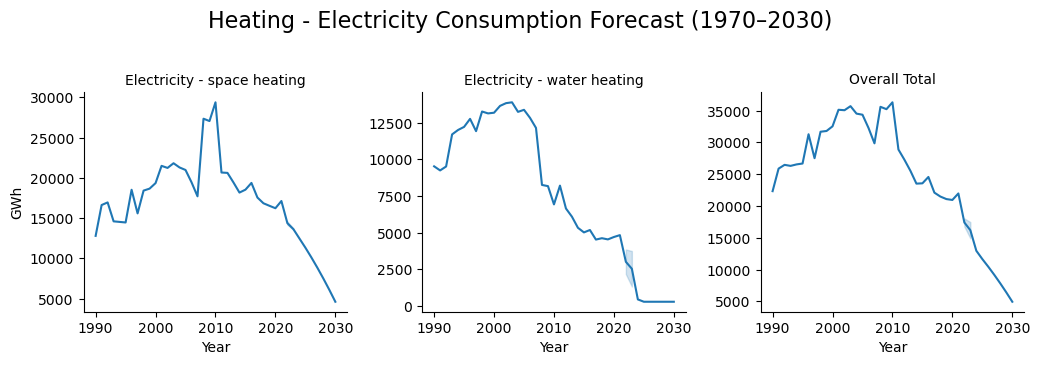

In [14]:
if melted.empty:
    print("No valid data to plot after merging historical and forecast values.")
else:
    matrix = sns.FacetGrid(melted, col="Category", col_wrap=3, height=3.5, sharey=False)
    matrix.map_dataframe(sns.lineplot, x="Year", y="Consumption (GWh)")
    matrix.set_titles("{col_name}")
    matrix.set_axis_labels("Year", "GWh")
    matrix.fig.suptitle("Heating - Electricity Consumption Forecast (1970–2030)", fontsize=16, y=1.03)
    plt.tight_layout()
    for ax in matrix.axes.flat:
        ax.set_xticks(range(1990, 2031, 10))
    plt.show()

In [15]:
full_filtered_heating_data.to_csv("Heating Electricity Consumption Forcast.csv", index=False)